# Coding Challenge: Gene Knockout Analysis with Embeddings - Task 4: Apply the In-Silico Perturbation Workflow to target ALS genes

In this notebook, we want to target previously reported genes linked to amyotrophic lateral sclerosis (ALS) and provide a ranking of genes as potential drug targets.

Here we use the `helical` package for the workflow.  

In [2]:
%load_ext autoreload
%autoreload 2

## Load packages

In [3]:
import logging
import warnings

import os

import numpy as np
import pandas as pd

import anndata as ann
import scanpy as sc
import umap

from helical.models.geneformer import Geneformer, GeneformerConfig
from helical.utils import mapping
import torch

import seaborn as sns
import matplotlib.pyplot as plt


/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
INFO:datasets:PyTorch version 2.6.0 available.


In [4]:
sc.logging.print_versions()

Package,Version
numpy,1.26.4
pandas,2.2.2
anndata,0.12.4
scanpy,1.11.5
umap-learn,0.5.9.post2
helical,1.4.6
torch,2.6.0
seaborn,0.13.2
matplotlib,3.10.7
Component,Info


Import custom code for perturbation and perturbation analysis.

In [5]:
from anndata_perturbation import AnnDataPerturbationModel
from perturbation_analysis import PerturbationAnalyzer

## Set paths and load data

In [6]:
project_path = './'
data_dir = os.path.join(project_path, "data")
table_dir = os.path.join(project_path, "tables")
figure_dir = os.path.join(project_path, "figures")
# set scanpy figure path in addition
sc.settings.figdir = os.path.join(project_path, "figures")
# load data in anndata format
adata = sc.read(os.path.join(project_path, data_dir, "counts_combined_filtered_BA4_sALS_PN.h5ad"))

## Load model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Set model configuration. 

In [8]:
model_config = GeneformerConfig(model_name="gf-12L-95M-i4096", batch_size=10, device=device)
geneformer_v2 = Geneformer(model_config)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cpu' with embedding mode 'cell'.


## Rationale of the in-silico perturbation experiment

According to the review of [Wang et al.](https://doi.org/10.3389/fnins.2023.1170996) in Frontiers in Neuroscience in 2023, currently several genes are linked to ALS. However, only 10% of the ALS cases were associated with genetic factors. 

The following genes have been previously identified to link to ALS: *SOD1, ANXA11, ARPP21, CAV1, C21ORF2, CCNF, DNAJC7, GLT8D1, KIF5A, NEK1, SPTLC1, TIA1, TARDBP, FUS*, and *WDR7*. In addition, a recent study by [Pineda et al.](https://www.cell.com/cell/fulltext/S0092-8674(24)00234-4) in Cell 2024, identified alterations in *C9orf72* to be linked with both ALS and frontotemporal lobar degeneration (FTLD). From a pharmaceutical angle, the pathway of integrated stress response (ISR) has been found altered and led to the development of several drug candidates acting as eIF2B activators (see [Marlin et al.](https://bpspubs.onlinelibrary.wiley.com/doi/10.1111/bph.16260) and [Flores et al.](https://www.nature.com/articles/s41467-025-63031-y)) to reduce the ISR activity and prevent neurodegeneration.  

To investigate the impact of perturbations in the given data set, we may explore the following options:
1. Run single gene perturbations
2. Run combinations of gene perturbations
3. Run pathway perturbations

The computationally cleanest approach would be to investigate single gene perturbations, which allowed us to identify the genes with strongest impact on healthy cells and identify the ones which generate a perturbation that is resembling the disease phenotype the most. From the biological perspective, option 3 would make the most sense, e.g. use the combination of genes involved in RNA metabolism (*TIA1, TARDBP, FUS*, and *C9orf72*), but which would not directly allow to identify a specific target. However, a combination of single gene perturbations and pathway perturbations could provide useful context in the strength of individual factors vs combinatorial perturbations. 

In the following, we will perform a knockdown experiment of genes involved in RNA metabolism (*TIA1, TARDBP, FUS*, and *C9orf72*). We chose the knockdown scenario because mutations in *TARDBP* reportedly led to overexpression and accumulation of its gene product TDP-43 in ALS, an  RNA binding protein (RBP) involved in RNA processing (see [Flores et al.](https://www.nature.com/articles/s41467-025-63031-y)).  

## Process data and generate embeddings

We noted previously that the `anndata` object does not encompass any data processing except for initial cell and gene filtering, or low-dimensional embeddings. 

Here we use the `helical` wrapper function for the `geneformer` Transcriptome Tokenizer to process the data. 

For the perturbation modeling of ALS, we subset the data to the `ALS` condition to study how a perturbation of the diseased state would resemble a healthy state - but we use the subset of ALS cells only for the perturbation experiments. We do not further subset to any cell types because we want to explore if there are cell-type specific effects of the perturbation. 

**Comment:** To keep the compute time on my MacBook in a reasonable time frame (i.e. less than 70 h to compute an embedding), I subset the data to 2,000 observations.

In [9]:
adata_2k = sc.pp.sample(adata, n=2000, copy = True)

In [10]:
# Initialize (tokenizes and embeds original data once)
perturb_model = AnnDataPerturbationModel(
    foundation_model=geneformer_v2,
    adata=adata_2k,
    normalize_embeddings=True
)

INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing original data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing original embeddings...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


Original embeddings shape: (2000, 512)


## Simulate a knockdown

Here we set up the knockdown experiment of genes involved in the RNA metabolism as single gene perturbation.

In [11]:
genes_to_perturb = ['TIA1', 'TARDBP', 'FUS', 'C9orf72']

For the following perturbation analysis, we subset to the `ALS` condition.

In [12]:
celltype_mask = adata_2k.obs['Condition'] == 'ALS'
celltype_indices = np.where(celltype_mask)[0]

In [60]:
# Perturb each gene in the list individually
results_batch = perturb_model.batch_perturbation(
    gene_list=genes_to_perturb,
    perturbation_type='knockdown',
    cell_indices=celltype_indices,
    reduction_factor=0.5
)


[1/4] Processing TIA1...
Creating perturbed AnnData (knockdown: TIA1, factor=0.5)...


INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.



[2/4] Processing TARDBP...
Creating perturbed AnnData (knockdown: TARDBP, factor=0.5)...


INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.



[3/4] Processing FUS...
Creating perturbed AnnData (knockdown: FUS, factor=0.5)...


INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.



[4/4] Processing C9orf72...
Creating perturbed AnnData (knockdown: C9orf72, factor=0.5)...


INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


## Save results and embeddings to file

In [14]:
import pickle

In [61]:
with open(os.path.join(data_dir, 'perturbmodel_2k_04.pkl'), 'wb') as handle:
    pickle.dump(perturb_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
with open(os.path.join(data_dir, 'perturbmodel_2k_batch_knockdown.pkl'), 'wb') as handle:
    pickle.dump(results_batch, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analysis of the in-silico perturbation experiment

In the previous section, we have established a retionale for the in-silico perturbation experiments. Specifically, we performed knockdown experiments for genes involved in the RNA metabolism (*TIA1, TARDBP, FUS*, and *C9orf72*), which are all linked to ALS via increased the integrated stress response (ISR) pathway. 

We performed single gene knockdown perturbations and analyze the results of the individual perturbations in the following.

Create analysis object and show ranking of perturbations.

In [66]:
analyzer = PerturbationAnalyzer(results_batch)
rankings = analyzer.rank_by_effect_size(top_k=10, metric='cosine', cell_indices=celltype_mask)


In [67]:
rankings

,gene,mean_distance,std_distance,median_distance,max_distance,n_cells
0,C9orf72,0.000062,0.000143,0.0,0.001771,1251
1,TARDBP,0.000037,0.000132,0.0,0.002401,1251
2,FUS,0.000031,0.000081,0.0,0.001343,1251
3,TIA1,0.000001,0.000019,0.0,0.000585,1251


Note: From the overall effect size on this dataset, *C9orf72* and *TARDBP* seem to have the strongest impact (strongest mean distance and median distance, respectively), followed by *FUS*. However, the effects seem very small overall. 

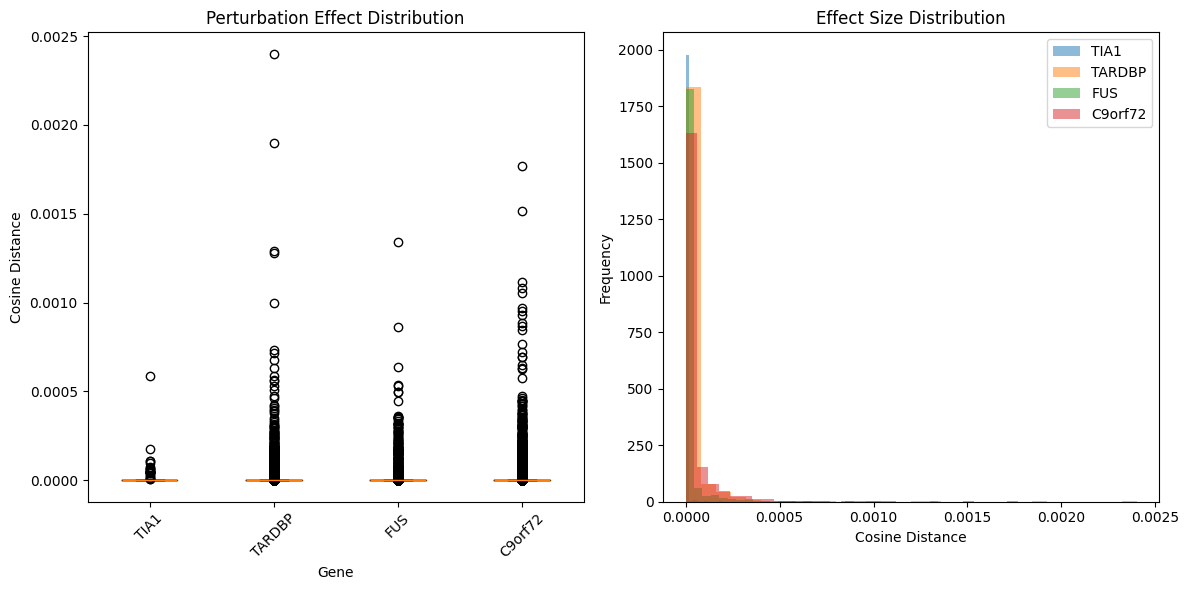

In [68]:
fig = analyzer.plot_effect_distribution(metric='cosine')
plt.show()

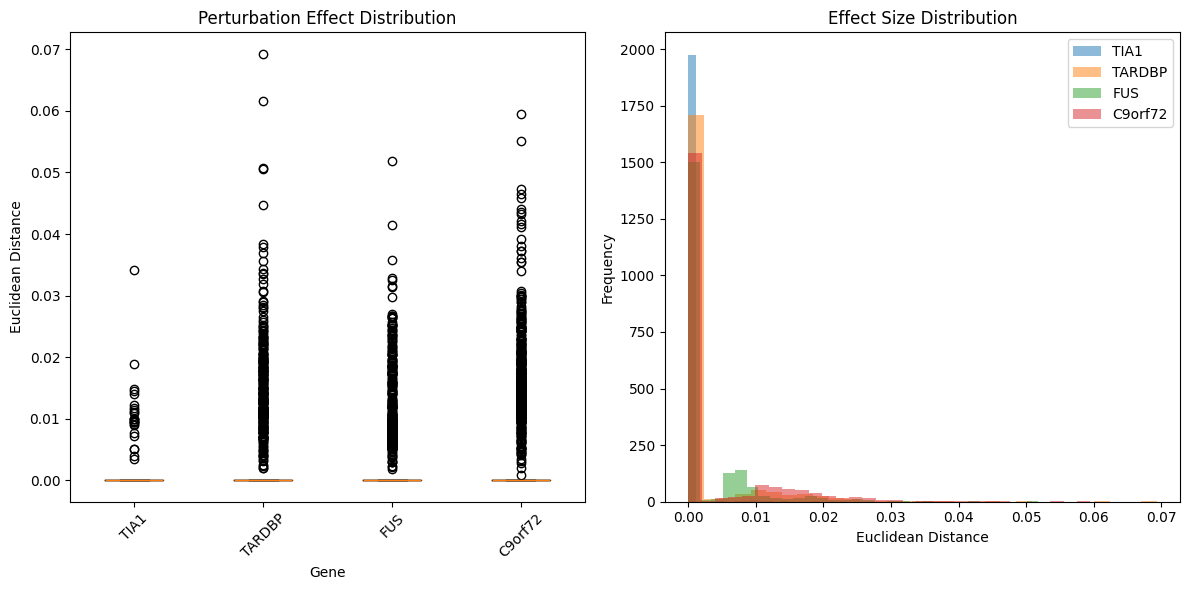

In [69]:
fig = analyzer.plot_effect_distribution(metric='euclidean')
plt.show()

Let us inspect the impact of the perturbation on a UMAP plot, one per perturbation.

  warn(

  warn(

  warn(

  warn(



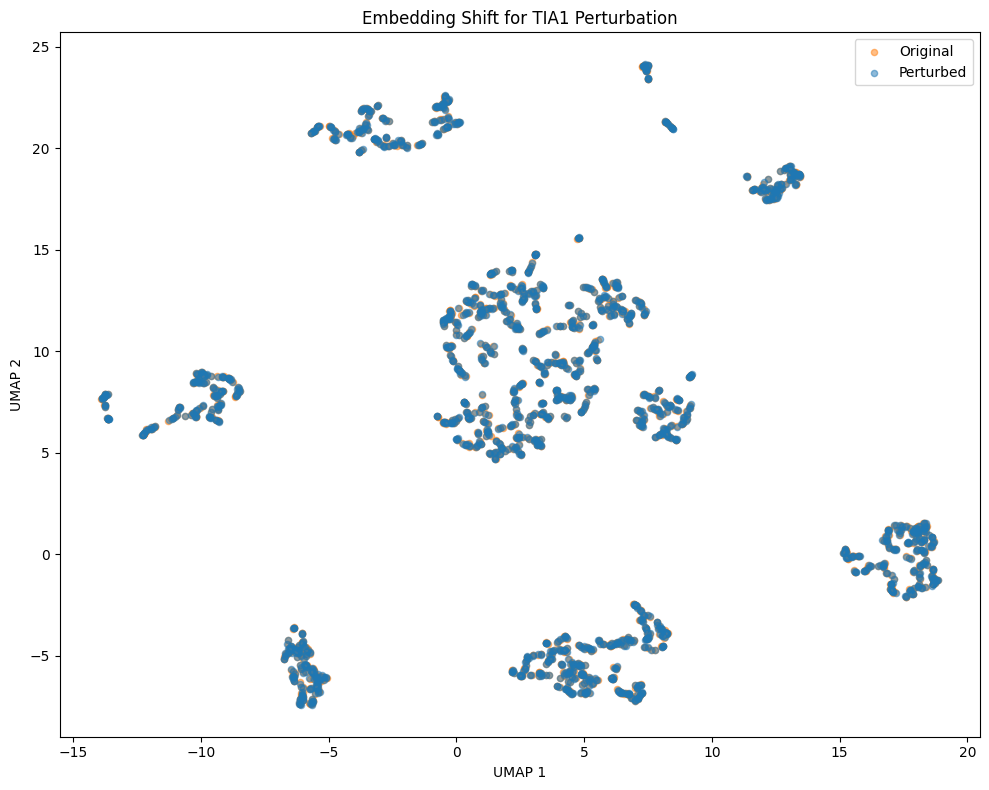

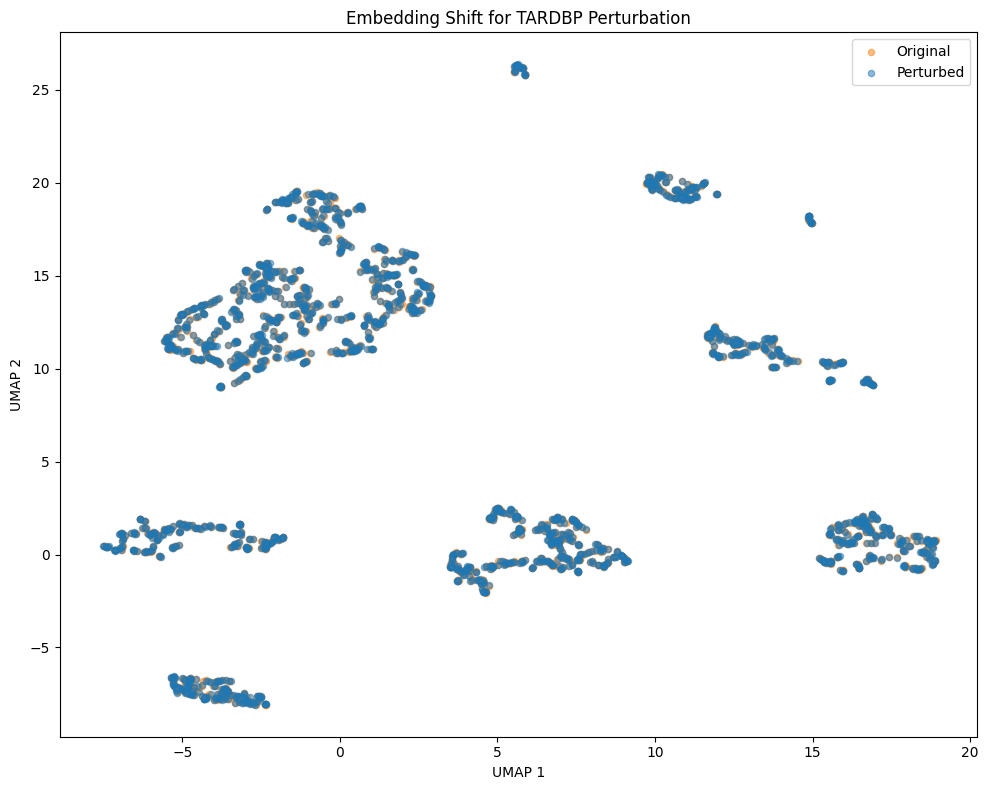

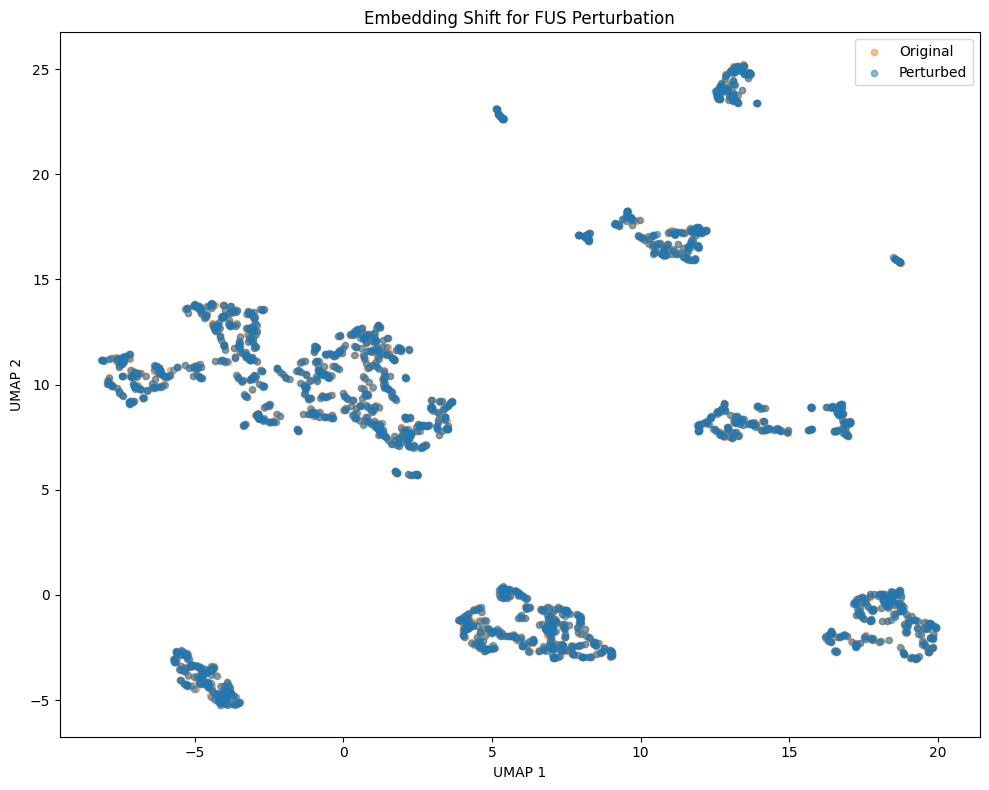

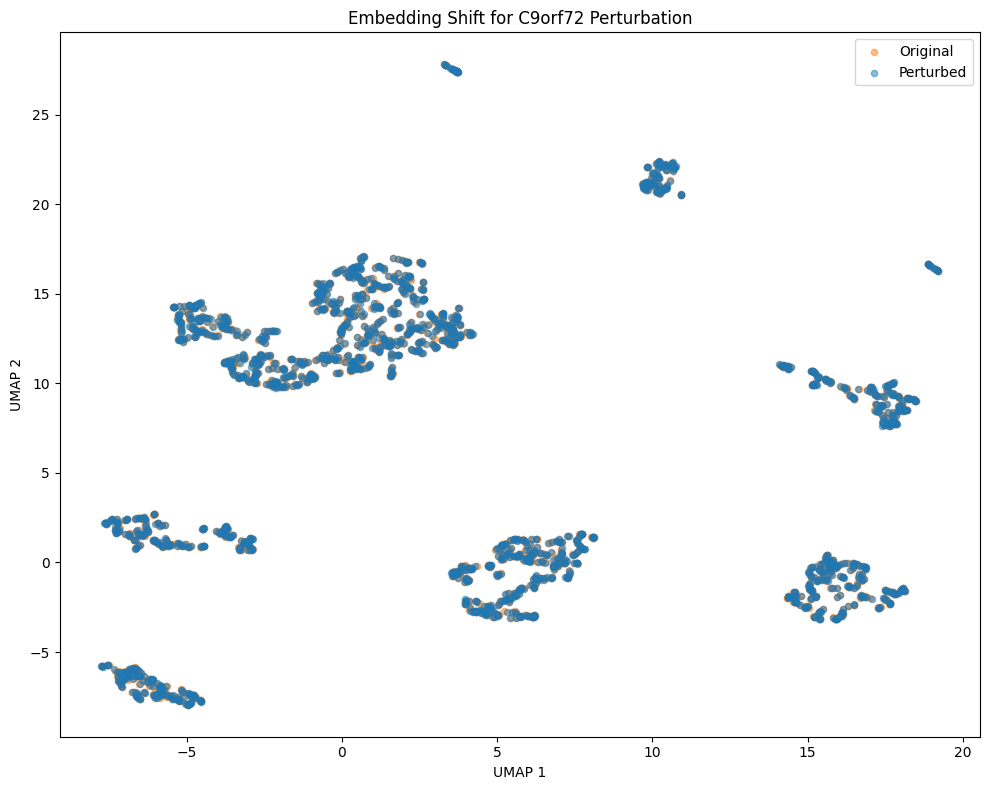

In [70]:
fig_list = []
for idx, gene in enumerate(genes_to_perturb):
    fig_list.append(analyzer.plot_embedding_shift(gene=gene, method='umap', figsize=(10,8)))
plt.show()

Again, shifts seem relatively small on the UMAP, with no clear distinction per cluster (cell type) or disease type.

Let us determine the shifts per cluster (cell type) of the diseased cells.

In [71]:
condition = perturb_model.adata.obs['Condition'].cat.codes.tolist()
condition_names = perturb_model.adata.obs['Condition'].tolist()

In [72]:
celltype = perturb_model.adata.obs['CellType'].cat.codes.tolist()
celltype_names = perturb_model.adata.obs['CellType'].tolist()

Combine labels for cell type and condition.

In [73]:
celltype_condition = np.array(celltype) * 2 + np.array(condition)
celltype_condition_names = [celltype_names[idx] + ' ' + condition_names[idx] for idx in range(len(condition_names))]

In [74]:
results_batch['TARDBP'].original_embeddings.shape

(2000, 512)

  warn(



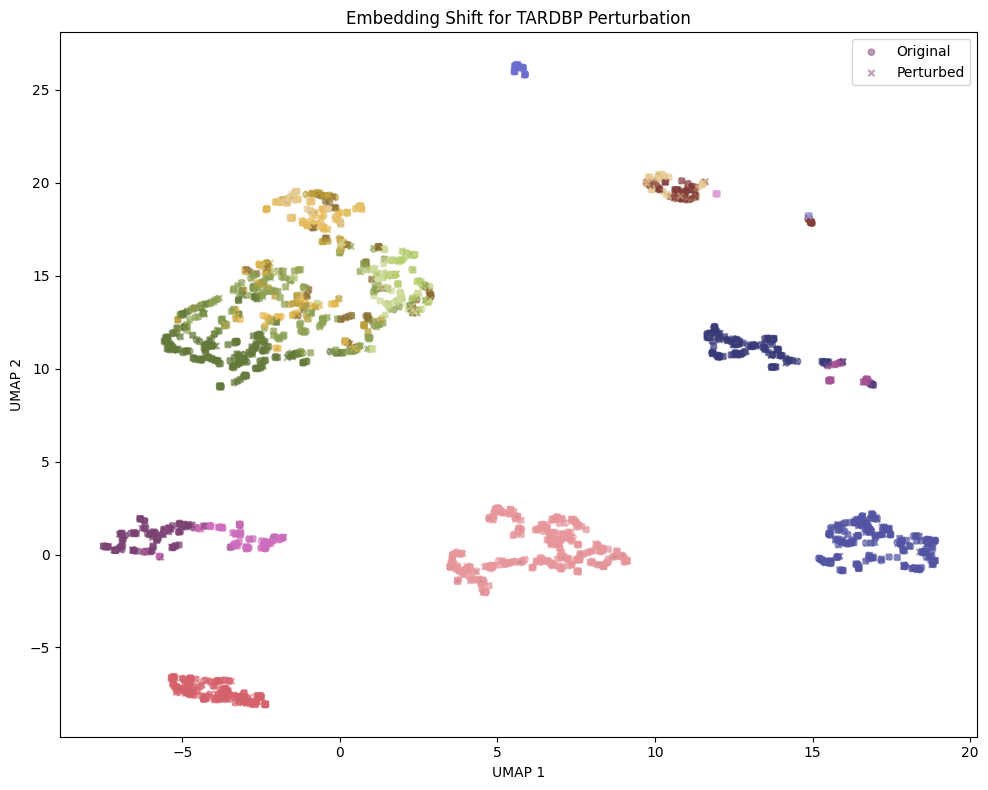

In [75]:
fig = analyzer.plot_embedding_shift(gene='TARDBP', method='umap', 
                                    color=celltype_condition, figsize=(10,8))
plt.show()

In [76]:
distance_list = []
for gene in genes_to_perturb:
    distance = results_batch[gene].compute_distances(metric='cosine')
    distance_list.append(pd.DataFrame(
        {gene : distance, 
         'celltype' : celltype_condition_names}, 
        index = perturb_model.adata.obs_names).groupby('celltype').mean())

In [77]:
distance_by_cluster = distance_list[0].join(distance_list[1:])

In [78]:
distance_by_cluster.style.background_gradient(axis=None, vmin=0, vmax=5e-4, cmap='YlGnBu').format(precision=5)

,TIA1,TARDBP,FUS,C9orf72
celltype,,,,
5HT3aR ALS,0.00000,0.00003,0.00002,0.00004
5HT3aR PN,-0.00000,-0.00000,-0.00000,-0.00000
Astro ALS,0.00000,0.00001,0.00001,0.00001
Astro PN,-0.00000,-0.00000,-0.00000,-0.00000
Endo ALS,0.00000,0.00001,0.00002,0.00006
Fibro ALS,-0.00000,-0.00000,0.00001,-0.00000
L2_L3 ALS,0.00000,0.00006,0.00004,0.00009
L2_L3 PN,-0.00000,-0.00000,-0.00000,-0.00000
L3_L5 ALS,0.00000,0.00006,0.00005,0.00013


The table above illustrates the mean shift per cell type in each of the perturbations on ALS cells when we half the expression of genes in the RNA metabolism pathway. Both *TARDBP* and *C9orf72* seem to affect L2_L3 and L3_L5 upper motor neurons (UMNs) the strongest, while *TIA1* did not seem to affect any of the cell types in particular. *C9orf72* knockdown affects L5 UMNs the strongest. 
We also observe that the difference in perturbation for the `PN` cells is negligible, because we did not change the gene expression of these cells. 

Lastly, let us determined the mixing of individual neighborhoods through neighborhood analysis. 

In [79]:
for gene in genes_to_perturb:
    # Quick check - single mixing score
    mixing = results_batch[gene].compute_mixing_score(k=15)
    print(f"Mixing in {gene}: {mixing:.3f}")  # > 0.8 = weak, < 0.5 = strong

Mixing in TIA1: 0.933
Mixing in TARDBP: 0.932
Mixing in FUS: 0.931
Mixing in C9orf72: 0.929


In [80]:
bias_list = []
alpha = 0.05

for gene in genes_to_perturb:
    # Detailed statistical analysis
    bias_result = results_batch[gene].test_neighborhood_bias(k=15)
    print(f"Significant cells: {bias_result['summary']['pct_significant']:.1f}%")
    print(f"Original-biased: {bias_result['n_original_biased']}")
    print(f"Perturbed-biased: {bias_result['n_perturbed_biased']}")

    # Per-cell detailed analysis
    detailed = results_batch[gene].test_neighborhood_bias(k=15, return_all_cells=True)
    bias_list.append(pd.DataFrame(
        {gene : detailed['p_values']<alpha, 
         'celltype' : celltype_condition_names + celltype_condition_names}, 
        index = range(len(detailed['p_values'])) ).groupby('celltype').mean())

Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0


In [81]:
bias_by_cluster = bias_list[0].join(bias_list[1:])

In [82]:
bias_by_cluster.style.background_gradient(axis=None, vmin=0, vmax=5e-4, cmap='YlGnBu').format(precision=5)

,TIA1,TARDBP,FUS,C9orf72
celltype,,,,
5HT3aR ALS,0.00000,0.00000,0.00000,0.00000
5HT3aR PN,0.00000,0.00000,0.00000,0.00000
Astro ALS,0.00000,0.00000,0.00000,0.00000
Astro PN,0.00000,0.00000,0.00000,0.00000
Endo ALS,0.00000,0.00000,0.00000,0.00000
Fibro ALS,0.00000,0.00000,0.00000,0.00000
L2_L3 ALS,0.00000,0.00000,0.00000,0.00000
L2_L3 PN,0.00000,0.00000,0.00000,0.00000
L3_L5 ALS,0.00000,0.00000,0.00000,0.00000


Overall, the neighborhoods for all cell types appear very well mixed, which underscores the low impact of the perturbation overall. For a stronger change, we would have expected that perturbed cells group with other perturbed cells.